# Figure showing constraints on the $S_v$ - $L$ correlation 

This notebook reproduces Figure 2 on the $S_v$ - $L$ correlation constraints from "How well do we know the neutron-matter equation of state at the densities inside neutron stars? A Bayesian approach with correlated uncertainties" by BUQEYE members Christian Drischler, Dick Furnstahl, Jordan Melendez, and Daniel Phillips [[arXiv:2004.07232]](https://arxiv.org/abs/2004.07232).
It can be easily updated and extended.

The allowed region derived in that paper from χEFT calculations of infinite matter are shown
as the yellow ellipses (dark: 1σ, light: 2σ) and denoted “GP-B” (Gaussian Process–BUQEYE collaboration).
The option is given below to choose either the $\Lambda = 500\,$MeV or $\Lambda = 450\,$MeV potentials.

Experimental and other theoretical constraints are from work by Jim Lattimer and collaborators:
* J. M. Lattimer and Y. Lim, Astrophys. J. 771, 51 (2013), [arXiv:1203.4286](https://arxiv.org/abs/1203.4286).
* J. M. Lattimer and A. W. Steiner, Eur. Phys. J. A 50, 40 (2014), [arXiv:1403.1186](https://arxiv.org/abs/1403.1186).
* I. Tews, J. M. Lattimer, A. Ohnishi, and E. E. Kolomeit- sev, Astrophys. J. 848, 105 (2017), [arXiv:1611.07133](https://arxiv.org/abs/1611.07133).

If you use a version of the figure created from this notebook, please cite the notebook as ??.

In [1]:
%matplotlib inline

# Standard Python imports
import os
import numpy as np
from scipy.interpolate import CubicSpline, interp1d

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import seaborn as sns


In [2]:
def setup_rc_params(presentation=False):
    """
    Set up the formatting details for the figure.
    """
    if presentation:
        fontsize = 11
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

    mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
    mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9

    ppi = 72  # points per inch
    # dpi = 150
    mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = True
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

    mpl.rcParams['legend.title_fontsize'] = fontsize
    mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.borderaxespad'] = 0.8
    mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

    mpl.rcParams['hatch.linewidth'] = 0.6

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')

setup_rc_params()    

Pick a color palette below. The plot should change accordingly.

In [3]:
black = 'k'  # This is always the same regardless of palette choice
yellow = 'yellow'

# Flat palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
[purple, blue, grey, red, darkblue, green] = flatui
orange = '#f39c12'

# Or pick 'deep', 'muted', etc. from seaborn's palettes
# https://seaborn.pydata.org/tutorial/color_palettes.html
# [darkblue, orange, green, red, purple, brown, pink, grey, tan, blue] = sns.color_palette('deep')

# Another option:
# purple = 'magenta'; blue = 'cyan'; grey = '0.5'; red = 'red'; darkblue = 'b'; green = 'green'
# orange = 'orange'

## Setting the boundaries of  constraint regions 

### Using splines for upper and lower boundaries of experimental regions

Data for constraint regions for some of the experiments in the figure are stored in the data subdirectory in two csv files with pairs of Esym and L values on each line, one file for the upper boundary of the region and one for the lower boundary.

For masses there is a single data file, which is read in and separated by hand into the boundaries.

To add another constraint region, just follow the pattern for existing regions below.

In [4]:
# sampling points
Esym = np.linspace(25, 36, 401)  # Use many points for interpolating expt region

# The information and spline boundaries are accumulated in avail_srcs array.
avail_srcs = []

# Heavy-ion collisions (HIC)
data_HIC_upper = pd.read_csv("./data/HIC_upper.csv",names=['Esym', 'L']) 
data_HIC_lower = pd.read_csv("./data/HIC_lower.csv",names=['Esym', 'L']) 
spline_HIC_upper = CubicSpline(data_HIC_upper["Esym"], data_HIC_upper["L"])
spline_HIC_lower = CubicSpline(data_HIC_lower["Esym"], data_HIC_lower["L"])
avail_srcs.append({
    "label" : "HIC", "facecolor" : green, 'spline_lower': spline_HIC_lower,
    'spline_upper': spline_HIC_upper, 'Esym': Esym,
    'label_x': 0.8, 'label_y': 0.93, 'ha': 'right', 'va': 'top', 'label_color': 'k',
#     'reference': 'HIC: Tsang, M. B., Zhang, Y., Danielewicz, P., et al., PRL, 102, 122701',
    'reference': 'Tsang \\textit{et al.},\nPRL \\textbf{102}, 122701 (2009)',
})


# Sn neutron skin
data_Sn_upper = pd.read_csv("./data/Sn_skin_upper.csv", names=['Esym', 'L']) 
data_Sn_lower = pd.read_csv("./data/Sn_skin_lower.csv", names=['Esym', 'L']) 
spline_Sn_upper = CubicSpline(data_Sn_upper["Esym"], data_Sn_upper["L"])
spline_Sn_lower = CubicSpline(data_Sn_lower["Esym"], data_Sn_lower["L"])
avail_srcs.append({
    "label" : "Sn Neutron Skin", "facecolor" : blue, 'spline_lower': spline_Sn_lower,
    'spline_upper': spline_Sn_upper, 'Esym': Esym, 'alpha': 0.8,
    'label_x': 0.67, 'label_y': 0.15, 'ha': 'center', 'va': 'center', 'label_color': 'k',
    'rotation': -40.8,
#     'reference': 'Sn skin: Chen, L.-W., Ko, C. M., Li, B.-A.,  Xu, J., PRC, 82, 024321',
    'reference': 'Chen \\textit{et al.},\nPRC \\textbf{82}, 024321 (2010)',
})

# GDR
data_GDR_upper = pd.read_csv("./data/GDR_upper.csv", names=['Esym', 'L']) 
data_GDR_lower = pd.read_csv("./data/GDR_lower.csv", names=['Esym', 'L']) 
spline_GDR_upper = CubicSpline(data_GDR_upper["Esym"], data_GDR_upper["L"])
spline_GDR_lower = CubicSpline(data_GDR_lower["Esym"], data_GDR_lower["L"])
avail_srcs.append({
    "label" : "GDR", "facecolor" : red, 'spline_lower': spline_GDR_lower,
    'spline_upper': spline_GDR_upper, 'Esym': Esym,
    'label_x': 0.135, 'label_y': 0.02, 'ha': 'left', 'va': 'bottom', 'label_color': 'k',
#     'reference': 'GDR: Trippa, L., Colo, G.,  Vigezzi, E., PRC, 77, 061304',
    'reference': 'Trippa \\textit{et al.},\nPRC \\textbf{77}, 061304 (2008)',
})

# Pb dipole
data_Pb_upper = pd.read_csv("./data/Pb_dipole_upper.csv", names=['Esym', 'L']) 
data_Pb_lower = pd.read_csv("./data/Pb_dipole_lower.csv", names=['Esym', 'L']) 
spline_Pb_upper = CubicSpline(data_Pb_upper["Esym"], data_Pb_upper["L"])
spline_Pb_lower = CubicSpline(data_Pb_lower["Esym"], data_Pb_lower["L"])
pb_dipole_label = "Pb Dipole\nPolarizability"
avail_srcs.append({
    "label": pb_dipole_label, "facecolor" : black, 'spline_lower': spline_Pb_lower,
    'spline_upper': spline_Pb_upper, 'Esym': Esym,
    'hatch': 'xx',
#     'alpha': 0.5,
    'ha': 'center', 'va': 'center', 'label_color': 'k',
#     'label_x': 0.05, 'label_y': 0.26,
#     'bbox': True,
    'label_x': 0.025, 'label_y': 0.235,
    'bbox': True,
    'rotation': 29,
    'fontsize': 8,
#     'reference': 'Pb dipole: X. Roca-Maza, M. Brenna, G. Colo, M. Centelles, X. Vinas et al., PRC 88, 024316'
    'reference': 'Roca-Maza \\textit{et al.},\nPRC \\textbf{88}, 024316 (2013)'
})


# masses
# Here there is only one csv file and the upper and lower parts are identified "by hand"
data_masses = pd.read_csv("./data/masses.csv",names=['Esym', 'L'])

# Find the lower and upper parts manually, only used for experimental agreement region
data_masses_upper = data_masses[34:-1].sort_values(by='Esym')
data_masses_lower = data_masses[:34].sort_values(by='Esym')
spline_data_masses_upper = CubicSpline(data_masses_upper["Esym"], data_masses_upper["L"], extrapolate=False)
spline_data_masses_lower = CubicSpline(data_masses_lower["Esym"], data_masses_lower["L"], extrapolate=False)

avail_srcs.append({
    "label" : "Masses", "facecolor" : orange, 'Esym': data_masses['Esym'], 'L': data_masses['L'],
    'label_x': 0.36, 'label_y': 0.208, 'ha': 'center', 'va': 'center', 'label_color': 'k',
    'rotation': 60, 'use_spline': False, 'spline_upper': spline_data_masses_upper,
    'spline_lower': spline_data_masses_lower, 'alpha': 1,
#     'reference': 'Masses: Kortelainen,M., McDonnell, J., Nazarewicz, W. et al., PRC, 82, 024313 (2010)'
    'reference': 'Kortelainen \\textit{et al.},\nPRC \\textbf{82}, 024313 (2010)'
})



# IAS
# data_IAS = pd.read_csv("./data/IAS.csv",names=['Esym', 'L'])
data_IAS = pd.read_csv("./data/IAS_2017.csv",names=['Esym', 'L'])
data_IAS = data_IAS[:-2]

# Find the lower and upper parts manually, only used for experimental agreement region
# data_IAS_upper = data_IAS[24:-2].sort_values(by='Esym')
# data_IAS_lower = data_IAS[:24].sort_values(by='Esym')
# spline_data_IAS_upper = interp1d(
#     data_IAS_upper["Esym"], data_IAS_upper["L"], bounds_error=False, fill_value=np.NaN)
# spline_data_IAS_lower = interp1d(
#     data_IAS_lower["Esym"], data_IAS_lower["L"], bounds_error=False, fill_value=np.NaN)

avail_srcs.append({
    "label" : "IAS + $\Delta R$", "facecolor" : darkblue, 'Esym': data_IAS['Esym'], 'L': data_IAS['L'],
    'label_x': 0.8, 'label_y': 0.67, 'ha': 'right', 'va': 'top', 'label_color': 'w',
    'use_spline': False,
    'rotation': 50,
#     'reference': 'P. Danielewicz, P. Singh and J. Lee, Nucl. Phys. A958, 147 (2017)'
    'reference': 'Danielewicz \\textit{et al.},\nNPA \\textbf{958}, 147 (2017)'
#     'spline_upper': spline_data_IAS_upper,
#     'spline_lower': spline_data_IAS_lower
})



### Theoretical regions

In [5]:

# Hebeler
data_H = pd.read_csv("./data/H.csv", names=['Esym', 'L']) 
avail_srcs.append({
    "label" : "H", "facecolor" : purple, 'Esym': data_H['Esym'], 'L': data_H['L'],
    'label_x': 0.53, 'label_y': 0.35, 'ha': 'right', 'va': 'top', 'label_color': 'k',
    'use_spline': False,
#     'reference': 'H: Hebeler, K., Lattimer, J. M., Pethick, C. J.,  Schwenk, A, PRL, 105, 161102'
    'reference': 'Hebeler \\textit{et al.},\nPRL \\textbf{105}, 161102 (2010)'
})

# Gandolfi
data_G = pd.read_csv("./data/G.csv", names=['Esym', 'L']) 
avail_srcs.append({
    "label" : "G", "facecolor" : grey, 'Esym': data_G['Esym'], 'L': data_G['L'],
    'label_x': 0.65, 'label_y': 0.4, 'ha': 'right', 'va': 'top', 'label_color': 'k',
    'use_spline': False,
#     'reference': 'G: Gandolfi, S., Carlson, J.,  Reddy, S., PRC, 85, 032801'
    'reference': 'Gandolfi \\textit{et al.},\nPRC \\textbf{85}, 032801 (2012)'
})

## Unitary gas boundaries

In [6]:
#### Cell 1 ####
n0 = 0.157 # fm**-3
hbarc = 197.3269718 # MeV fm
Mn = 939.565379; # MeV
EUG0 = 3./(10.*Mn) * np.cbrt(3.*np.pi**2*n0)**2*hbarc**2*0.365 # about 12.64 MeV
E0 = -15.5 # MeV

TewsEtAlSetting = {
    "EUG0" : EUG0, "E0" : E0, "Kn" : 270,
    "Qnlower" : -750., "Qnupper" : 0.
}

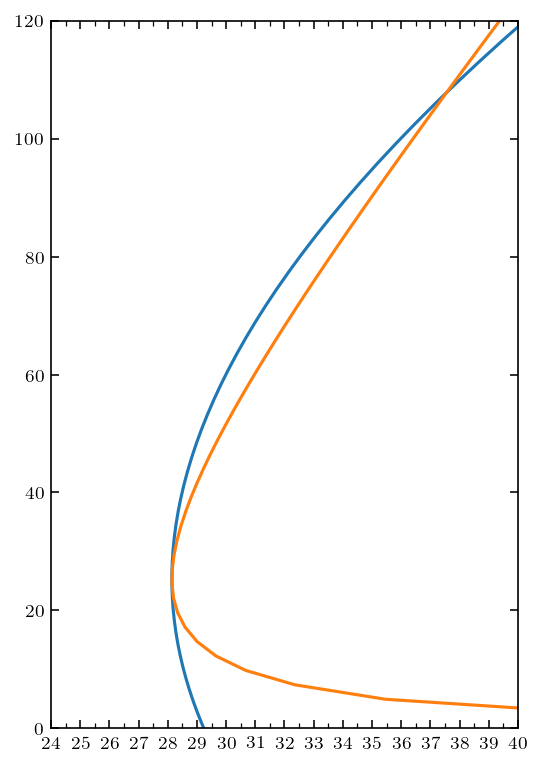

In [7]:
#### Cell 2 #### Label = UG
def getUgConstraint( ut, EUG0, Kn, Qnlower, Qnupper, E0 ):
    taylorDiff = ut-1.
    Qn = np.where(ut < 1, Qnlower, Qnupper)
    Esym = EUG0/(3.*np.cbrt(ut)) * (ut+2.) + Kn/18. * taylorDiff**2 + Qn/81. * taylorDiff**3 - E0
    L = 2.*EUG0/(np.cbrt(ut)) - Kn/3. * taylorDiff - Qn/18. * taylorDiff**2
    return Esym, L

def getUgAnalyticConstraint( L, EUG0, E0 ):
    return L/6. * ( 1. + 2. * (2.* EUG0 / L)**(3/2) ) - E0

#### Cell 3 #### Label “analytic UG”
fig, ax = plt.subplots(figsize=(3.5, 5))
ut=np.linspace(0.001,2,100)
Esym_tews, L_tews = getUgConstraint( ut, **TewsEtAlSetting)

ax.set_xlim(24, 40)
ax.set_ylim(0, 120)
plt.plot(Esym_tews, L_tews)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.xaxis.set_major_locator(MultipleLocator(1))
 
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
 
# now plot analytic constraint
L_grid =np.linspace(0.001,120)
plt.plot(getUgAnalyticConstraint(L_grid, EUG0, E0), L_grid)

Make sure that our interpolants correctly split the Masses and IAS into upper and lower parts:

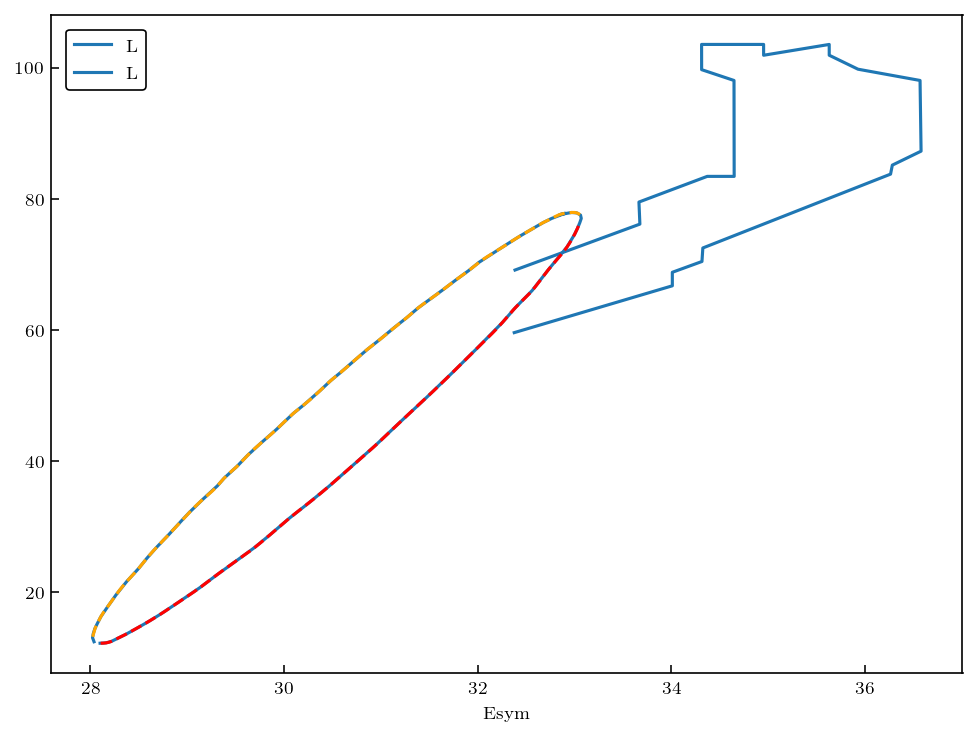

In [8]:
fig, ax = plt.subplots()
data_masses.plot('Esym', 'L', ax=ax, c='C0')
data_IAS.plot('Esym', 'L', ax=ax, c='C0')

ax.plot(Esym, spline_data_masses_upper(Esym), ls='--', c='orange')
ax.plot(Esym, spline_data_masses_lower(Esym), ls='--', c='red')


# ax.plot(Esym, spline_data_IAS_upper(Esym), ls='--', c='orange')
# ax.plot(Esym, spline_data_IAS_lower(Esym), ls='--', c='red');

In [9]:
# def getInterp(kind, upperLower, Esym):
#     functionName= "spline_{kind}_{upperLower}".format(kind=kind, upperLower=upperLower)
#     return eval(functionName)(Esym)

In [10]:
def find_agreement(Esym, labels, sources):
    lower_bound = - np.inf * np.ones(Esym.shape)
    upper_bound = + np.inf * np.ones(Esym.shape)
    for source in sources:
        if source['label'] in labels:
            if 'spline_lower' in source and 'spline_upper' in source:
                lower = source['spline_lower'](Esym)
                upper = source['spline_upper'](Esym)
                
#                 lower = np.where(np.isnan(lower), +np.inf, lower)
#                 upper = np.where(np.isnan(upper), -np.inf, upper)
                lower[np.isnan(lower)] = +np.inf
                upper[np.isnan(upper)] = -np.inf
            else:
                raise ValueError()
            
            lower_bound = np.where(lower > lower_bound, lower, lower_bound)
            upper_bound = np.where(upper < upper_bound, upper, upper_bound)
    return lower_bound, upper_bound

In [11]:
# expt_lower, expt_upper = find_agreement(
#     Esym, ['HIC', "Sn Neutron Skin", "GDR", pb_dipole_label, 'Masses', 'IAS'], avail_srcs
# )
expt_lower, expt_upper = find_agreement(
    Esym, ['HIC', "Sn Neutron Skin", "GDR", pb_dipole_label, 'Masses'], avail_srcs
)
expt_mask = expt_lower < expt_upper

In [12]:
# regularLineStyle = {"ls": "--", "lw" : 0.8}

# def plotSource(ax, kind, color, Esym):
#     if kind in ["H", "G", "masses", "IAS"]:
#         data = "data_" + kind
#         plt.fill(eval(data)["Esym"], eval(data)["L"], facecolor=color, edgecolor='k', **regularLineStyle)
#     else:
#         plt.fill_between(
#             Esym, getInterp(kind, "lower", Esym), getInterp(kind, "upper", Esym),
#             facecolor=color, edgecolor='k', **regularLineStyle
#         )

def plot_source(
    ax, Esym, L=None, spline_lower=None, spline_upper=None, use_spline=True,
    label=None, label_x=0, label_y=0, ha=None, va=None, reference=None,
    label_color='k', rotation=None, bbox=None, fontsize=None,
    facecolor=None, edgecolor='k', ls='-', lw=0.9, hatch=None,
    zorder=None, **kwargs
):
    if not use_spline:
        ax.fill(
            Esym, L, edgecolor=edgecolor, ls=ls, lw=lw, facecolor=facecolor,
            hatch=hatch, zorder=zorder, **kwargs
        )
    else:
        old_facecolor = facecolor
        if hatch is not None:
            facecolor = "none"
        ax.plot(Esym, spline_lower(Esym), c=edgecolor, ls=ls, lw=lw, zorder=zorder)
        ax.plot(Esym, spline_upper(Esym), c=edgecolor, ls=ls, lw=lw, zorder=zorder)
        ax.fill_between(
            Esym, spline_lower(Esym), spline_upper(Esym),
            edgecolor=old_facecolor, ls=ls, lw=0, facecolor=facecolor,
            hatch=hatch, zorder=zorder, **kwargs
        )

    if label is not None:
        if bbox is True:
            bbox = dict(facecolor='w', boxstyle='round', alpha=1)
        ax.text(
            label_x, label_y, label, fontdict=dict(color=label_color),
            rotation=rotation, transform=ax.transAxes, bbox=bbox,
            fontsize=fontsize
        )
    return ax

def add_ref(ref, ax):
    return ax.text(0.05, 0.92, ref, ha='left', va='top', transform=ax.transAxes)

## Confidence ellipse from calculations in the paper

In [13]:
# Choose Lambda = 500 MeV or 450 MeV by uncommenting one of the following lines.

Lambda = 500
#Lambda = 450

In [14]:
def confidence_ellipse(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

#     # Calculating the stdandard deviation of x from
#     # the squareroot of the variance and multiplying
#     # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
#     mean_x = np.mean(x)

#     # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
#     mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [15]:

if Lambda not in [450, 500]:
    raise ValueError('')

# n=0.17 +/- 0.01, Lambda = 500
if Lambda == 500:
    Esym_L_sat_eft = np.array([31.69810539, 59.830485  ])
    cov_Esym_L_eft = np.array([
        [ 1.23651375,  3.27499281],
        [ 3.27499281, 16.95157735],
    ])

# n=0.17 +/- 0.01, Lambda = 450
if Lambda == 450:
    Esym_L_sat_eft = np.array([33.52341527, 67.79737685])
    cov_Esym_L_eft = np.array([
        [ 1.57488007,  3.05934762],
        [ 3.05934762, 15.97354339],
    ])

Uncertainties at $1\sigma$

In [16]:
np.sqrt(cov_Esym_L_eft[0,0]), np.sqrt(cov_Esym_L_eft[1, 1])

(1.1119863982981086, 4.1172293292941555)

## Generate the incremental and full figures

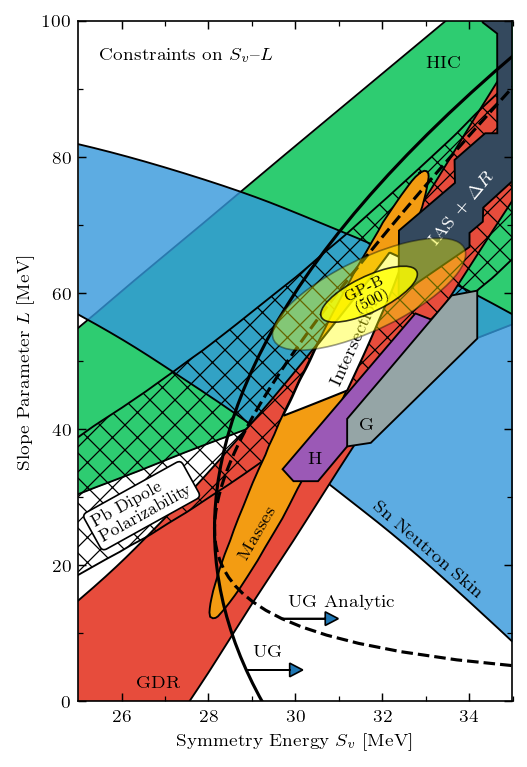

In [17]:
image_type = 'png'

import glob

# Just in case the number of plots changes
files = glob.glob('incremental_plots/*')
for f in files:
    os.remove(f)

def file_out(i, image_type='pdf'):
    """Generate a file name for sequential image output.
    """
    file_base = 'incremental_plots/Esym_L_correlation'
    return file_base + f'{i:02d}' + '.' + image_type

fig, ax = plt.subplots(figsize=(3.4, 5), constrained_layout=True)

# set labels and title
ax.set_xlabel(r"Symmetry Energy $S_v$ [MeV]")
ax.set_ylabel(r"Slope Parameter $L$ [MeV]")
# ax.set_title('$S_v$--$L$ Correlation')
ax.text(0.05, 0.96, 'Constraints on $S_v$--$L$', 
        transform=ax.transAxes, ha='left', va='top')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# set limits
ax.set_xlim(25, 35)
ax.set_ylim(0, 100)
ax.yaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
ax.tick_params(width=0.7, which='major')

# plot each source separately
i = 0
fig.savefig(file_out(i, image_type))
i += 1

# step through the array of constraint regions and plot in turn
for src in avail_srcs:  
    plot_source(ax, zorder=i/10., **src)
    ref = add_ref(src['reference'], ax)
    fig.savefig(file_out(i, image_type))
    ref.remove()
    i += 1
    if src['label'] == 'Masses':
        ax.fill_between(
            Esym[expt_mask], expt_lower[expt_mask], expt_upper[expt_mask],
            lw=1, facecolor='w', edgecolor='k', zorder=i/10
        )
        ax.text(
            0.64, 0.53, 'Intersection', transform=ax.transAxes,
            rotation=65.4, ha='center', va='center', zorder=i/10
        #     fontsize=7,
        )
        fig.savefig(file_out(i, image_type))
        i += 1
        
# Add the unitary gas constraint boundaries
ut = np.linspace(0.001, 2, 100)
tews_zorder = 11
Esym_tews, L_tews = getUgConstraint( ut, **TewsEtAlSetting)
ax.plot(Esym_tews, L_tews, c='k', zorder=tews_zorder)

idx_arrow_tews = 60
ax.arrow(Esym_tews[idx_arrow_tews], L_tews[idx_arrow_tews], 1, 0, head_length=0.3, head_width=2, zorder=tews_zorder)
ax.text(Esym_tews[idx_arrow_tews]+0.15, L_tews[idx_arrow_tews]+1.4, 'UG', ha='left', va='bottom', zorder=tews_zorder)

# now plot analytic constraint
L_grid = np.linspace(0.001, 120, 100)
Esym_tews_analytic = getUgAnalyticConstraint(L_grid, EUG0, E0)
ax.plot(Esym_tews_analytic, L_grid, c='k', ls='--', zorder=tews_zorder)

idx_arrow_tews_a = 10
ax.arrow(
    Esym_tews_analytic[idx_arrow_tews_a], L_grid[idx_arrow_tews_a], 1, 0,
    head_length=0.3, head_width=2, zorder=tews_zorder)
ax.text(Esym_tews_analytic[idx_arrow_tews_a]+0.15, L_grid[idx_arrow_tews_a]+1.4,
        'UG Analytic', ha='left', va='bottom', zorder=tews_zorder)

# ug_ref = 'UG: Tews, I., Lattimer, J. M., Ohnishi, A. , Kolomeitsev, E. E., APJ 848, 105'
ug_ref = 'Tews \\textit{et al.},\nAPJ \\textbf{848}, 105 (2017)'
ref = add_ref(ug_ref, ax)
i += 1
fig.savefig(file_out(i, image_type))
ref.remove()

# plot Drischler et al. (2016)
# Uncomment the next lines to show the individual data points from this paper.
# data_D = pd.read_csv("./data/Drischler_2016.csv", names=['Esym', 'L']) 
# ax.scatter(data_D["Esym"], data_D["L"], c="k", marker="*")
# stars_ref = 'Drischler \\textit{et al.},\nPRC \\textbf{93}, 054314 (2016)'
# ref = add_ref(stars_ref, ax)
# i += 1
# fig.savefig(file_out(i, image_type))
# ref.remove()

confidence_ellipse(
    Esym_L_sat_eft, cov_Esym_L_eft, ax=ax, n_std=2,
    facecolor=yellow, edgecolor='k', alpha=0.4, zorder=i+1
)
confidence_ellipse(
    Esym_L_sat_eft, cov_Esym_L_eft, ax=ax, n_std=1,
    facecolor=yellow, edgecolor='k', alpha=0.8, zorder=i+1
)

if Lambda == 500:
#     ax.text(
#         0.6045, 0.584, r'GP-B', fontdict=dict(color='k'),
#         rotation=26.7, transform=ax.transAxes,
#         zorder=i+2,
#     )
    ax.text(
        0.61, 0.588, r'GP-B', fontdict=dict(color='k', fontsize=7),
        rotation=26.7, transform=ax.transAxes,
        zorder=i+2,
    )
    ax.text(
        0.635, 0.572, r'(500)', fontdict=dict(color='k', fontsize=7),
        rotation=26.7, transform=ax.transAxes,
        zorder=i+2,
    )

elif Lambda == 450:
    ax.text(
        0.762, 0.641, r'GP-B (450)', fontdict=dict(color='k', fontsize=7),
        rotation=21, transform=ax.transAxes,
        zorder=i+2,
    )

ref = add_ref('This work', ax)
i += 1
fig.savefig(file_out(i, image_type))
ref.remove()

fig.savefig(f"Lattimer_Esym_L_Lambda-{Lambda}." + image_type)

## Create an animated gif showing constraints as overlays

The method used here requires [ImageMagick](https://imagemagick.org/) and assumes the incremental plots were created as png files. Increase the delay for more time before the next image. Set `-loop` to 0 to cycle endlessly and set to `n` to make n loops. 

In [18]:
%%bash

convert -delay 100 -loop 1 incremental_plots/*png incremental_plots/Esym_L_correlation_animated.gif